## Introduction

This tutorial will introduce you the basics in XGBoost algorithm, particularly focusing on regression predictive modeling problems. XGBoost is short for Extreme Gradient Boosting and is an cost-effective execution of the stochastic gradient boosting machine learning algorithm. We will use XGBoost to build a group of boosted trees, and use the continuous and cateforical data from Auto-MPG Dataset to predict the  'mpg' attribute. We are also going to visulize the XGBoost trees and explain the most important aspects or practical details of the math behind it.

### Tutorial content

In this tutorial, we'll learn how to define the XGBRegressor model and predict regression data in Python, specifically using [XGBoost](https://xgboost.readthedocs.io/en/latest/), and package [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) which is a function that comes in Scikit-learn’s model_selection package, and package [Graphviz](https://graphviz.readthedocs.io/en/stable/) to draw the XGBoost trees.

We'll be using data collected from the __Auto MPG Data Set__ from __UCI Machine Learning Repository__: http://archive.ics.uci.edu/ml/datasets/Auto+MPG. It should be noted that XGBoost is designed for large complicated data sets. However, to keep the examples from getting out of hand, we will use this rather simple data set to demonstrate the applicaton of XGBoost from start to finish. Also note that XGBoost can be applied to both classification and regression problems. Using the work flow shown in this tutorial, you can apply XGBoost to a large number of data sets.

We will cover the following topics in this tutorial:
- [Installing the Libraries](#Installing-the-libraries)
- [Loading Data from a File](#Loading-Data-from-a-File)
- [Formatting the Data for XGBoost](#Formatting-the-Data-for-XGBoost)
- [Building a Preliminary XGBoost Model](#Building-a-Preliminary-XGBoost-Model)
- [Optimizing Parameters with Cross Validation and GridSeach()](#Optimizing-Parameters-with-Cross-Validation-and-GridSeach())
- [Visulizing the Optimized XGBoost Model](#Visulizing-the-Optimized-XGBoost-Model)
- [Understanding the Basic Math](#Understanding-the-Basic-Math)

## Installing the libraries

Before getting started, you'll need to install the various libraries that we will use. You can install XGBoost, scikit-learn and Graphviz using `conda`:

    $ conda install -c conda-forge xgboost
    
    $ conda install -c anaconda scikit-learn
    
    $ conda install graphviz python-graphviz
    
If you've already installed these packages for a while, it's recommended to update all of your Anaconda packages with the following command:

    $ conda update --all

There are some other very fundamental and essential packages in this tutorial, including numpy, pands, matplotlib, ..., which are all conda installable and therefore we will not linger nastily over the details. 

In [345]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb

from sklearn.model_selection import train_test_split # to split data into training and testing sets
from sklearn.model_selection import GridSearchCV # for cross validation
from sklearn.metrics import mean_absolute_error # for model evaluation
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

***

## Loading Data from a File

Now that we've installed and loaded the libraries, let's load our __Auto MPG Data__. We first need to download the data and description from the UCI Machine Learning Repository website: http://archive.ics.uci.edu/ml/datasets/Auto+MPG and save them to a folder.

We're going to load data provided under the name 'auto-mpg.data', which stores data in a specific shape wihtout header. We will also load the data description file 'auto-mpg.names'.

As the '.data' file only contain numbers, we will first look into the description file using the following command:

In [346]:
with open('/Users/rubyjiang/Desktop/15688_PDS/Tutorial/auto-mpg.names') as f:
    print(f.read())

1. Title: Auto-Mpg Data

2. Sources:
   (a) Origin:  This dataset was taken from the StatLib library which is
                maintained at Carnegie Mellon University. The dataset was 
                used in the 1983 American Statistical Association Exposition.
   (c) Date: July 7, 1993

3. Past Usage:
    -  See 2b (above)
    -  Quinlan,R. (1993). Combining Instance-Based and Model-Based Learning.
       In Proceedings on the Tenth International Conference of Machine 
       Learning, 236-243, University of Massachusetts, Amherst. Morgan
       Kaufmann.

4. Relevant Information:

   This dataset is a slightly modified version of the dataset provided in
   the StatLib library.  In line with the use by Ross Quinlan (1993) in
   predicting the attribute "mpg", 8 of the original instances were removed 
   because they had unknown values for the "mpg" attribute.  The original 
   dataset is available in the file "auto-mpg.data-original".

   "The data concerns city-cycle fuel consumptio

We can see from the above information, there are in total 398 observations, each observation has 9 features, including __mpg__, __cylinders__,__displacement__, __horsepower__, __weight__, __acceleration__, __model year__, __origin__, and __car name__, among which horsepower has 6 missing values. Next, we are going to load the '.data' file into a data frame called df with header from the description using the following command:

In [347]:
col_names = ['mpg','cylinders','displacement','horsepower','weight','acceleration','model year','origin','car name']
df = pd.read_table('/Users/rubyjiang/Desktop/15688_PDS/Tutorial/auto-mpg.data', header=None, delim_whitespace=True, names=col_names)
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino


***

## Formatting the Data for XGBoost
From the description, we know that the last column 'car name' is unique for each instance, and will not be useful for regression. So we will leave out this variable. All other columns contains a lot of different values, so will keep the rest of them. For the sake of simplicity, I'm only showing to first 10 uniqe values for horsepower, acceleration, and model year.

In [348]:
df['mpg'].unique()[:10]

array([18., 15., 16., 17., 14., 24., 22., 21., 27., 26.])

In [349]:
df['cylinders'].unique()

array([8, 4, 6, 3, 5])

In [350]:
df['horsepower'].unique()[:10]

array(['130.0', '165.0', '150.0', '140.0', '198.0', '220.0', '215.0',
       '225.0', '190.0', '170.0'], dtype=object)

In [351]:
df['acceleration'].unique()[:10]

array([12. , 11.5, 11. , 10.5, 10. ,  9. ,  8.5,  8. ,  9.5, 15. ])

In [352]:
df['model year'].unique()[:10]

array([70, 71, 72, 73, 74, 75, 76, 77, 78, 79])

In [353]:
df['origin'].unique()

array([1, 3, 2])

In [354]:
len(df['car name'].unique())

305

Let's get rid of the column named 'car name'.

In [355]:
df.drop(['car name'], axis=1, inplace=True) # set axis=0 to remove rows, axis=1 to remove columns
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


We have removed data that will not help us create an effective XGBoost model. Now we are ready to deal with __Missing Data__ in the __horsepower__ column. Let's first check out the data types of each feature.

In [356]:
df.dtypes

mpg             float64
cylinders         int64
displacement    float64
horsepower       object
weight          float64
acceleration    float64
model year        int64
origin            int64
dtype: object

If we look at the output above, we see that 'horsepower' looks like a bunch of numbers. However, if we look at the data type for 'horsepower', we see that it is an object. We usually get object when we have a mixture of numbers and characters. Let's check it out.

In [357]:
df['horsepower'].unique()

array(['130.0', '165.0', '150.0', '140.0', '198.0', '220.0', '215.0',
       '225.0', '190.0', '170.0', '160.0', '95.00', '97.00', '85.00',
       '88.00', '46.00', '87.00', '90.00', '113.0', '200.0', '210.0',
       '193.0', '?', '100.0', '105.0', '175.0', '153.0', '180.0', '110.0',
       '72.00', '86.00', '70.00', '76.00', '65.00', '69.00', '60.00',
       '80.00', '54.00', '208.0', '155.0', '112.0', '92.00', '145.0',
       '137.0', '158.0', '167.0', '94.00', '107.0', '230.0', '49.00',
       '75.00', '91.00', '122.0', '67.00', '83.00', '78.00', '52.00',
       '61.00', '93.00', '148.0', '129.0', '96.00', '71.00', '98.00',
       '115.0', '53.00', '81.00', '79.00', '120.0', '152.0', '102.0',
       '108.0', '68.00', '58.00', '149.0', '89.00', '63.00', '48.00',
       '66.00', '139.0', '103.0', '125.0', '133.0', '138.0', '135.0',
       '142.0', '77.00', '62.00', '132.0', '84.00', '64.00', '74.00',
       '116.0', '82.00'], dtype=object)

You can find that there is a special character '?' in the 'horsepower' column. So we need to deal with this.

One thing that is unique for XGBoost is that it determines default behavior for missing data. 
Before that, let's see how many rows are missing data.

In [358]:
len(df.loc[df['horsepower']=='?'])

6

We see that __6__ rows have missing values, let's look at them.

In [359]:
df.loc[df['horsepower']=='?']

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin
32,25.0,4,98.0,?,2046.0,19.0,71,1
126,21.0,6,200.0,?,2875.0,17.0,74,1
330,40.9,4,85.0,?,1835.0,17.3,80,2
336,23.6,4,140.0,?,2905.0,14.3,80,1
354,34.5,4,100.0,?,2320.0,15.8,81,2
374,23.0,4,151.0,?,3035.0,20.5,82,1


Those 6 observations have missing values are of cylinders 4 and 6. We have several options to deal with the missing values. We can set the 'horsepower' to the mean or median of 'horsepower' found in the other observations that have 'cylinders' value 4 and 6, respectively. Or we can simply remove these 6 observations. In this example, we will remove these 6 cases. 

In [360]:
# drop 
df = df[df['horsepower'] != '?']
df.shape

(392, 8)

Note that 'horsepowet' still is of type 'object', which is not the type that XGBoost allows. Let's fix this by converting it to numeric values.

In [361]:
df['horsepower'] = pd.to_numeric(df['horsepower'])

In [362]:
df.dtypes

mpg             float64
cylinders         int64
displacement    float64
horsepower      float64
weight          float64
acceleration    float64
model year        int64
origin            int64
dtype: object

In [363]:
df

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1
...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1


We have successfully dealt with missing values and object type columns. All columns are either float or int type, which is good. However, we still have to look into the __cylinders__, __model year__, and __origin__ columns becasue they are __`multi-valued discrete`__ though they are in numeric form. This is becasue XGBoost does not support categorical data. In our case, the categorical data, i.e., cylinders, model year, and origin, are already in numerical form, treated them like continuous data, by natural order encoding. However, the drawback of this encoding method is that we are implying that, for example, being cylinder type 8 is more similar to being cylinder type 6 than other forms of cylinder type. This is definitely not what we mean to imply. Another encoding method that can help us avoid this issue is called __One-Hot-Encoding__. By using one-hot-encoding, we treat each category as a seperate feature that is the same level of importance and similarity with any other category. One way of doing so is to use the pands `get_dummies` method.

In [364]:
df_encoded = pd.get_dummies(df, columns=['cylinders', 'model year', 'origin'])
df_encoded.head()

,mpg,displacement,horsepower,weight,acceleration,cylinders_3,cylinders_4,cylinders_5,cylinders_6,cylinders_8,...,model year_76,model year_77,model year_78,model year_79,model year_80,model year_81,model year_82,origin_1,origin_2,origin_3
0,18.0,307.0,130.0,3504.0,12.0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
1,15.0,350.0,165.0,3693.0,11.5,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
2,18.0,318.0,150.0,3436.0,11.0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
3,16.0,304.0,150.0,3433.0,12.0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
4,17.0,302.0,140.0,3449.0,10.5,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0


Now, one last thing to do before we build an XGBoost model, is that we need to seperate the data into two parts. The first part is the features ot columns of data that we will use to make predictions, and we will use the conventional notation of a capital X, __`X`__. The second part is the column of data that we want to predict, which is the __mpg__ in this tutorial, and we will use a lower case __`y`__ to represent this one column.

In [365]:
X = df_encoded.drop('mpg', axis=1).copy()
y = df_encoded['mpg'].copy()

In [366]:
y.describe()

count    392.000000
mean      23.445918
std        7.805007
min        9.000000
25%       17.000000
50%       22.750000
75%       29.000000
max       46.600000
Name: mpg, dtype: float64

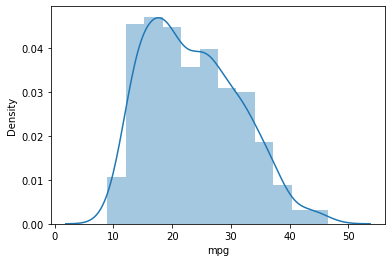

In [367]:
import seaborn as sns
sns.distplot(y);

Note that by default pandas copy by _reference_. In the above code, we are using `copy()` method to copy the data by _value_ so that we can make sure the original data `df_encoded` is intact. So if something wrong happens, we can go back to the original data frame and redo what we wanted to. Now we have finally finished the data formatting procedure  and we are ready to make our first XGBoost model.

***

## Building a Preliminary XGBoost Model

We first split the data into training and testing sets.

In [368]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, train_size=0.75, random_state = 42)

Before we build the model, let's first check the distribution of __y_train__ and __y_test__ to make sure that they are not too different from each other.

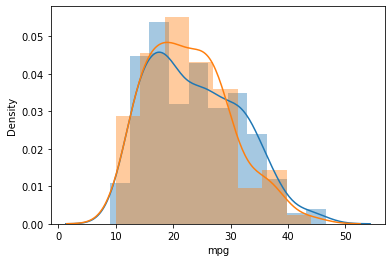

In [369]:
sns.distplot(y_train);
sns.distplot(y_test);

It turns out as expected both y_train and y_test have similar distribution. Now let's build the model. Instead of finding out the optimal number of trees with cross validation, we will use __early stopping__ to stop building trees when there is no longer any improvement.

There are multiple evaluation metric you can turn to when doing regression. We are going to use __mean absolute error (MAE)__ as the evaluation metric to evaluate the accuracy of our predictions. MAE is a common and simple metric that has the advantage of being in the same unit as our target, which means it can be compared to target values and easily interpreted. For XGBoost classification problem, you can use, for example, 'aucpr' as the evaluation metric.

In [370]:
#https://ml.dask.org/modules/generated/dask_ml.xgboost.XGBRegressor.html
#https://github.com/dmlc/xgboost/blob/master/doc/parameter.rst
reg_xgb = xgb.XGBRegressor(verbosity=0, 
                           objective='reg:squarederror', 
                           missing=None, 
                           seed=42)
reg_xgb.fit(X_train, 
            y_train, 
            eval_metric= 'mae', #'mae', # 'rmsle', 'rmse'
            early_stopping_rounds=11,
            eval_set=[(X_test, y_test)])

[0]	validation_0-mae:15.23467
[1]	validation_0-mae:10.31782
[2]	validation_0-mae:6.99288
[3]	validation_0-mae:4.86059
[4]	validation_0-mae:3.60962
[5]	validation_0-mae:2.91023
[6]	validation_0-mae:2.55142
[7]	validation_0-mae:2.37789
[8]	validation_0-mae:2.34730
[9]	validation_0-mae:2.32124
[10]	validation_0-mae:2.31774
[11]	validation_0-mae:2.31866
[12]	validation_0-mae:2.31456
[13]	validation_0-mae:2.30251
[14]	validation_0-mae:2.30401
[15]	validation_0-mae:2.28332
[16]	validation_0-mae:2.29724
[17]	validation_0-mae:2.28917
[18]	validation_0-mae:2.27458
[19]	validation_0-mae:2.26852
[20]	validation_0-mae:2.26150
[21]	validation_0-mae:2.26159
[22]	validation_0-mae:2.26427
[23]	validation_0-mae:2.26771
[24]	validation_0-mae:2.25649
[25]	validation_0-mae:2.25175
[26]	validation_0-mae:2.25322
[27]	validation_0-mae:2.25548
[28]	validation_0-mae:2.25587
[29]	validation_0-mae:2.25816
[30]	validation_0-mae:2.25190
[31]	validation_0-mae:2.25896
[32]	validation_0-mae:2.25724
[33]	validation_0-

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=None, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=0)

In [371]:
y_train_pred = reg_xgb.predict(X_train)
score = r2_score(y_train, y_train_pred)
print("R² Training Score: %.5f "% score)

R² Training Score: 0.99937 


We have successfully build a preliminary XGBoost model for regression. Before we evalute it on the testing data, let's
looking at how the performance would look like if we _just_ predicted the mean target output on the training set just as what we did in homework 2. 

In [373]:
#https://blog.cambridgespark.com/hyperparameter-tuning-in-xgboost-4ff9100a3b2f
# "Learn" the mean from the training data
mean_train_pred = np.mean(y_train)
# Get predictions on the test set
baseline_predictions = np.ones(y_test.shape) * mean_train_pred
#baseline_predictions = np.ones(y_test.shape) * np.mean(y_train)
# Compute MAE
mae_baseline = mean_absolute_error(y_test, baseline_predictions)
print("Baseline MAE is {:.2f}".format(mae_baseline))

Baseline MAE is 5.96


The baseline MAE is about 6 if we predict the output of testing with the mean value of the training target value. We will compare the baseline MAE to the testing MAE to evaluate our model.

Now let's see how it performs on the __testing data set__ by running the testing dataset down the current XGBoost model and compare the __MAE__ and __R² score__ with that of the training dataset.

In [374]:
y_test_pred = reg_xgb.predict(X_test)
mae = mean_absolute_error(y_test, y_test_pred)
print("MAE on test: %.5f" % mae)

MAE on test: 2.22527


In [180]:
score = r2_score(y_test, y_test_pred)
print("R² Testing Score: %.5f "% score)

R^2 Testing Score: 0.81010 


Clearly we see that the MAE on testing data 2.23 is much smaller than the baseline MAE 5.96, whcih is saying that our preliminary model is doing its job.

We see that the mean absolute error on training data and testing data is 2.229 and 2.225, respectively, which looks to be good. However, the R² score does not seem to be good enough on the testing set. So, the preliminary XGBoost model was not excellent enough. Now Let's try to improve our preliminary model by tunning several hyperparameters using __cross validation__.

***

## Optimizing Parameters with Cross Validation and GridSeach()

XGBoost has a lot of __hyperparameters__, which are parameters that are not determined by XGBoost itself but we have manual control. Several most common hyperparameters that we usually optimize for regression modeling are `max_depth`, the maximum depth of the XGBoost trees, `learning_rate`, `gamma`, the paramater that help prune, `reg_lambda`, the regularization parameter, `min_child_weight`, the minimum number of instance weight (hessian) needed in a child. So, let's try to find the optimal values for these hyperparameters in hopes that we can improve the performance of the XGBoost model on the __testing data__. 

Note that there are more hyperparameters in XGBoost that we are not going to cover in this tutorial, and for regression and classification, the hyperparameters that need to be optimized are different. For more information, visit this website: https://xgboost.readthedocs.io/en/latest/parameter.html.

Since we have a bunch of hyperparameter to optimize, we will use GridSearchCV(). We specify several potential values for the hyperparameters, then GridSearchCV() tests all possible combinations of the parameters for us. This process usually take some time depending on how many combinations you have.

Note that to speed up the cross validation process, and to further keep overfitting from happening, I will use 90% of the data by specifying 'subsample=0.9', and use half of the features by 'colsample_bytree=0.5' per tree during cross validation.

In [375]:
## Round 1 
param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.005, 0.01, 0.05, 0.1],
    'gamma': [0, 0.25, 1.0],
    'reg_lambda': [0, 1, 10],
    'min_child_weight': [5, 6, 7, 8]
}

In [376]:
optimal_params= GridSearchCV(
    estimator = xgb.XGBRegressor(objective='reg:squarederror', 
                                 missing=None, 
                                 seed=42,
                                 subsample=0.9,
                                 colsample_bytree=0.5),
    param_grid = param_grid,
    scoring = 'neg_mean_absolute_error', # https://scikit-learn.org/stable/modules/model_evaluation.html
    verbose=2, # set verbose to 0 if you are not interested in what XGBoost is doing.
    n_jobs=10,
    cv=3 # 3 fold cross validation, 10 fold   
)

optimal_params.fit(X_train,
                   y_train,
                   early_stopping_rounds=10,
                   eval_metric='mae',
                   eval_set=[(X_test, y_test)],
                   verbose=False)

Fitting 3 folds for each of 432 candidates, totalling 1296 fits


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None, colsample_bytree=0.5,
                                    gamma=None, gpu_id=None,
                                    importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=None, monotone_constraints=None,
                                    n_estimators=100, n_jobs=...
                                    num_parallel_tree=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, seed=42,
                                    subsample=0.9, tree_method=None,
       

In [377]:
print(optimal_params.best_params_)

{'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 8, 'reg_lambda': 1}


Here I'm going to do a second round hyperparameter tunning, becasue we can see that some of the optical parameters found in the fisrt round, i.e., learning_rate, max_depth, min_child_weight, , fall on the edge of the range that we provided. So in the second round, we are going to go further on that direction.

In [378]:
## Round 2
param_grid = {
    'max_depth': [5,7,9,12],
    'learning_rate': [0.1, 0.2, 0.3], #[0.1, 0.5, 1],
    'gamma': [0],
    'reg_lambda': [1, 3, 6],
    'min_child_weight': [8, 9, 10, 11]
}
optimal_params= GridSearchCV(
    estimator = xgb.XGBRegressor(objective='reg:squarederror', 
                                 missing=None, 
                                 seed=42,
                                 subsample=0.9,
                                 colsample_bytree=0.5),
    param_grid = param_grid,
    scoring = 'neg_mean_absolute_error',
    verbose=2,
    n_jobs=10,
    cv=3
)

optimal_params.fit(X_train,
                   y_train,
                   early_stopping_rounds=10,
                   eval_metric='mae',
                   eval_set=[(X_test, y_test)],
                   verbose=False)
print(optimal_params.best_params_)

Fitting 3 folds for each of 144 candidates, totalling 432 fits
{'gamma': 0, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 10, 'reg_lambda': 1}


In [379]:
print(optimal_params.best_params_)

{'gamma': 0, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 10, 'reg_lambda': 1}


After the parameter tunning, we have the optimal parameters. The next step we will do is to build the XGBoost model with these optimized hyperparamers.

### Build and Evaluate the Optimized XGB Model

In [380]:
reg_xgb = xgb.XGBRegressor(seed = 42,
                           objective='reg:squarederror',
                           gamma = 0,
                           learning_rate = 0.1,
                           max_depth = 7,
                           min_child_weight = 10,
                           reg_lambda = 1,
                           subsample = 0.9,
                           colsample_bytree = 0.5)

reg_xgb.fit(X_train, 
            y_train, 
            verbose = True,
            eval_metric='mae', # 'rmsle'
            early_stopping_rounds=10,
            eval_set=[(X_test, y_test)])

[0]	validation_0-mae:19.93432
[1]	validation_0-mae:17.84982
[2]	validation_0-mae:15.99264
[3]	validation_0-mae:14.28313
[4]	validation_0-mae:12.80040
[5]	validation_0-mae:11.40781
[6]	validation_0-mae:10.17950
[7]	validation_0-mae:9.07124
[8]	validation_0-mae:8.11191
[9]	validation_0-mae:7.21718
[10]	validation_0-mae:6.41137
[11]	validation_0-mae:5.72048
[12]	validation_0-mae:5.10383
[13]	validation_0-mae:4.57840
[14]	validation_0-mae:4.15106
[15]	validation_0-mae:3.77683
[16]	validation_0-mae:3.50256
[17]	validation_0-mae:3.30342
[18]	validation_0-mae:3.13311
[19]	validation_0-mae:3.00589
[20]	validation_0-mae:2.85306
[21]	validation_0-mae:2.73208
[22]	validation_0-mae:2.64634
[23]	validation_0-mae:2.58290
[24]	validation_0-mae:2.54536
[25]	validation_0-mae:2.50884
[26]	validation_0-mae:2.44908
[27]	validation_0-mae:2.40770
[28]	validation_0-mae:2.39548
[29]	validation_0-mae:2.35233
[30]	validation_0-mae:2.32341
[31]	validation_0-mae:2.29851
[32]	validation_0-mae:2.29176
[33]	validati

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=7,
             min_child_weight=10, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
             subsample=0.9, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [381]:
y_train_pred = reg_xgb.predict(X_train)
score = r2_score(y_train, y_train_pred)
print("R² Training Score: %.5f "% score)

R² Training Score: 0.95322 


In [382]:
y_test_pred = reg_xgb.predict(X_test)
mae = mean_absolute_error(y_test, y_test_pred)
print("MAE on test: %.5f" % mae)
score = r2_score(y_test, y_test_pred)
print("R² Testing Score: %.5f "% score)

MAE on test: 2.08906
R² Testing Score: 0.82193 


|  | Preliminary model | Optimized model |
| --- | --- | --- |
| Training set | MAE = 2.22890, R² = 0.99937 | MAE = 2.09747, R² = 0.95322 |
| Testing set | MAE = 2.22527, R² = 0.81010 | MAE = 2.08906, R² = 0.82193 |

From the table, we can see that the optimized XGBoost model is performing better on testing data though the performcne on training data is sacrificed a little. The second last thing we are going to do in this tutorial is to draw the optimized XGBoost trees and interpret it.

## Visulizing the Optimized XGBoost Model

In the `to_graphviz()` method, we need to specify `num_trees` a integer value. Note that this is not the number of trees to plot, but the one specific tree that you are interested in. Let's plot __the first tree__ in the XGBoost Trees to show the features and feature values for each split as well as the output leaf nodes.

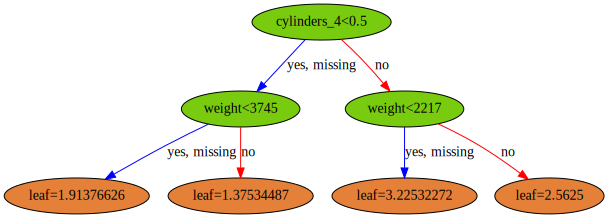

In [383]:
reg_xgb = xgb.XGBRegressor(seed = 42,
                           objective='reg:squarederror',
                           gamma = 0,
                           learning_rate = 0.1,
                           max_depth = 7,
                           min_child_weight = 10,
                           reg_lambda = 1,
                           subsample = 0.9,
                           colsample_bytree = 0.5)

reg_xgb.fit(X_train, 
            y_train, 
            verbose = False,
            eval_metric='mae', # 'rmsle'
            early_stopping_rounds=10,
            eval_set=[(X_test, y_test)])
# bst = reg_xgb.get_booster()
# for importance_type in ('weight', 'gain', 'cover', 'total_gain', 'total_cover'):
#     print('%s: ' % importance_type, reg_xgb.get_score(importance_type=importance_type))
    
#https://github.com/dmlc/xgboost/issues/3858
node_params = {'share': 'box',
               'style': 'filled, rounded',
               'fillcolor': '#78cbe'}
leaf_params = {'share': 'box',
               'style': 'filled',
               'fillcolor': '#e48038'}

xgb.to_graphviz(reg_xgb, 
                num_trees=0, 
                #size='3，3',
                condition_node_params=node_params,
                leaf_node_params=leaf_params)

We can also have a look of the feature importances returned by XGBoost. We see that __displacement__ dominates the other features, standing out as the most important indicator for `mpg`. Following displacement, the other 3 important features are __weight__, __acceleration__, and __horsepower__. 

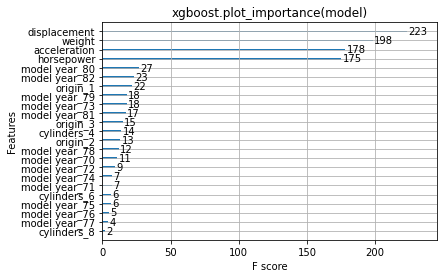

In [384]:
model = reg_xgb
xgb.plot_importance(model)
plt.title("xgboost.plot_importance(model)")
plt.show()

XGBoost also other offers options for measuring feature importance by: 
- Weight. The number of times a feature is used to split the data across all trees. 
- Cover. The number of times a feature is used to split the data across all trees weighted by the number of training data points that go through those splits.
- Gain. The average training loss reduction gained when using a feature for splitting.

Weigth is the default option, so the figure above shows a weight-based importance. Now, let's check out the other two options.

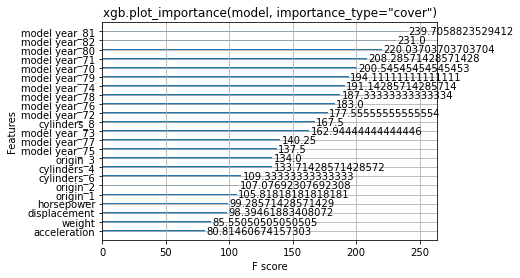

In [385]:
xgb.plot_importance(model, importance_type="cover")
plt.title('xgb.plot_importance(model, importance_type="cover")')
plt.show()

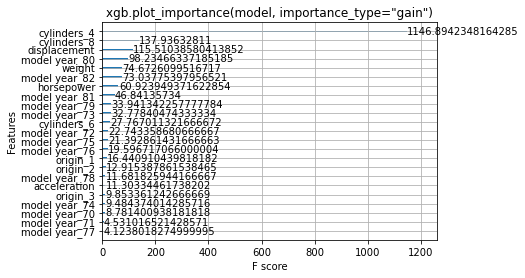

In [386]:
xgb.plot_importance(model, importance_type="gain")
plt.title('xgb.plot_importance(model, importance_type="gain")')
plt.show()

Now, you may ask, how XGBoost algorith determines the sequence of feature to split, and how is the __gain__ calculated in the XGBoost model. Let's dive into the basic mathematical details to help us better understand the algorithm.

## Understanding the Basic Math

To demonstrate the mathematical detial behind XGBoost, I will focus on regression and briefly mention the math for classification. First, let's use the first tree we just draw up there to build an intuition about how XGBoost performs regression with its unique tree. 

The very first step in training an XGBoost model to training data is to make an initial prediction. This prediction is specified by `base_score=0.5`, which means by default the initial prediction is __0.5__ regardless if you are building XGBoost model for regression or classification. Exactly the same as unextreme gradient boost, XGBoost fits a regression tree to the residuals. Unlike unextreme gradient boost which usually uses regular, off-the-shelf, regression trees, XGBoost use a different regression tree which we will call it XGBoost tree. 

One of the common way to build such a XGBoost tree is that each tree starts with a single leaf, and all of the residuals go to the leaf. Now we can calculate the `Similarity Score` for the leaf. The similarity score is shown as follows:

$$  \text{Similarity Score} = \sum^{m}  \frac{(y - \hat{y})^2}{m + \lambda}  $$ 

where $m$ is the number of instances in the leaf, $y$ is true value, $\hat{y}$ is the predicted value, and $\lambda$ is the regularization term.

For example, we have four instances from training data, their true mpg values $y$, and predicted mpg values $\hat{y}$ as follows:

In [387]:
X_train[0:4]['cylinders_4']

267    1
16     0
67     0
160    0
Name: cylinders_4, dtype: uint8

In [388]:
y = y_train[0:4].values
y

array([27.5, 18. , 11. , 17. ])

In [389]:
y_hat = y_train_pred[0:4]
y_hat 

array([27.169771, 19.287565, 12.552174, 16.86122 ], dtype=float32)

Let's calculate the similarity score for the first leaf, we will take $\lambda = 0$ for now. At the first step our initial prediction for all instances is 0.5.

In [390]:
lam = 0
m = 4
y = y_train[0:4].values
y_hat = [0.5] * m
SS_root = sum((y-y_hat)**2)/ (m + lam)
print('The similarity score for the root is: %.5f'% SS)

The similarity score for the root is: 354.43750


Now the question is which threshold to use to seperate the instances into tow clusters to do a better job. For the four instances we have in hand, the average of the first two observations on the column 'cylinders_4' is 0.5. So we seperate our observations based on whether or not its __'cylinders_4' < 0.5__. Then the first observation goes to the left leaf, and the other three goes to the right leaf. Now, let's calculate the similarity score for the two new leaf we have.

For the leaf one, there is one observation:

In [391]:
SS_left = (y[0] - y_hat[0])**2/ (1 + lam)
print('The similarity score for the left leaf is: %.5f'% SS_left )

The similarity score for the left leaf is: 729.00000


For the right leaf, there are three observations:

In [392]:
SS_right = sum((y[1:] -  y_hat[1:])**2)/ (3 + lam)
print('The similarity score for the right leaf is: %.5f'% SS_right )

The similarity score for the right leaf is: 229.58333


Now we have the similarity for each node. Let's quantify how much better the leaves cluster similar residuals than the root by calculate the `Gain`. The Gain is simple the sum of the similarity score for the leaves minus the similarity score for the root. In this case, our gian is:

In [393]:
gain = SS_left + SS_right - SS_root
gain

604.1458333333334

Since there are only 2 values for the column `cylinders_4`, 0.5 will be the final threshold we will use. However, if we are going to continue building the tree, like the one we draw, by splitting the observations based on `weight`, we need to calculate the gain of each of the three thresholds and then pick the one with the highest gain.

To calculate the __Output Values__, the following equation is used:

$$ \text{Output values} =  \sum^{m}  \frac{(y - \hat{y})}{m + \lambda} $$


Now, let's assume we build the first XGBoost tree with only splitting on the feature cylinders_4, let try to see how thr output values will be:

In [394]:
output_left = (y[0] - y_hat[0])/(1 + lam)
output_right =  sum(y[1:] -  y_hat[1:])/ (3 + lam)
print('The predicted value for the left leaf is %.5f'% output_left)
print('The predicted value for the right leaf is %.5f'% output_right)
print('The true value for these 4 observations are:', y)

The predicted value for the left leaf is 27.00000
The predicted value for the right leaf is 14.83333
The true value for these 4 observations are: [27.5 18.  11.  17. ]


We can see with this extremely simple tree we are reaching a fairly good prediction for the 4 examples. So far, we have learned that XGBoost starts with an initial prediction of 0.5 for both regression and classification. We also learned to evaluate how good the initial prediction is by calculating the residuals, i,e., the difference between the true value and the predicted value. Just like any cannonical machine learning algorithm, we can use a __Loss Function__ to quantify how good our predciton is. 

For XGBoost regression:

$$ L(y, \hat{y}) = \sum^{m}_{m=0} \frac{1}{2}(y-\hat{y})^2 + \frac{1}{2} \lambda O^2_{value}$$

For XGBoost classification: 

$$ L(y, \hat{y}) = -\sum^{m}_{m=0} [y\log(\hat{y}) + (1-y)\log(1-\hat{y})] $$

The first part is the loss funciton, the second part is composed of a regularization term $\lambda$ and  XGBoost builds trees by minimizing the loss functions. For more nitty gritty of the mathematical details, please check out the original xgboost paper and tutorials designed for this, for example, this following link does a good job: https://medium.com/analytics-vidhya/what-makes-xgboost-so-extreme-e1544a4433bb

## Summary and references

This tutorial demonstrated how to build an __XGBoost__ model for __regression__ problem and how to evalute and optimize the model with __Auto MPG Data Set__ in Pyhton. Basic __math__ detials behind the model are explained briefly with four observations from the data set. Much more detail about the XGBoost libraries and questions are available from the following links.

1. XGBoost: https://github.com/dmlc/xgboost
2. Auto MPG Data Set: http://archive.ics.uci.edu/ml/datasets/Auto+MPG
3. The original XGBoost paper: https://arxiv.org/pdf/1603.02754.pdf
4. XGBoost documentation: https://xgboost.readthedocs.io/en/latest/
